In [ ]:
# %pip install python-dotenv dashscope requests matplotlib pillow

In [13]:
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv("./env/.env"))

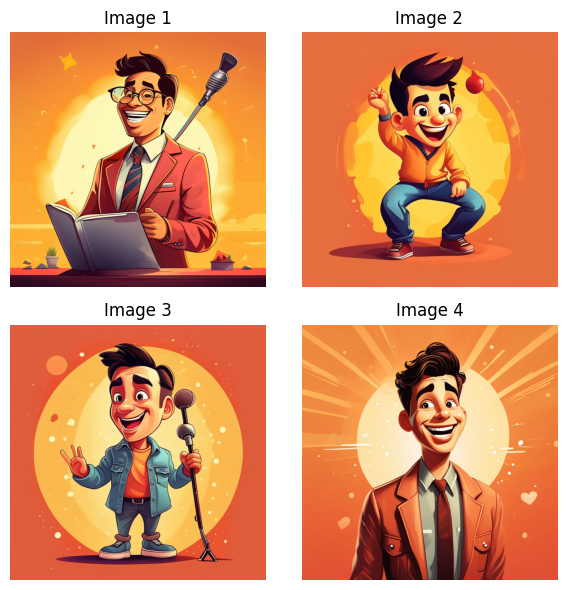

In [16]:
from http import HTTPStatus
import dashscope
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
import os

def simple_call():
    urls = []
    prompt = "卡通风格的图片，里面是一个喜剧演员正在表演 standup comedy"
    rsp = dashscope.ImageSynthesis.call(
        model=dashscope.ImageSynthesis.Models.wanx_v1,
        prompt=prompt,
        n=4,
        size="1024*1024",
        api_key=os.getenv("DASHSCOPE_API_KEY"),
    )
    if rsp.status_code == HTTPStatus.OK:
        # save file to current directory
        for result in rsp.output.results:
            urls.append(result.url)
    else:
        print(
            "Failed, status_code: %s, code: %s, message: %s"
            % (rsp.status_code, rsp.code, rsp.message)
        )

    return urls


def display_images_in_grid(image_urls):
    # 创建2x2的子图布局
    fig, axes = plt.subplots(2, 2, figsize=(6, 6))

    # 扁平化axes数组以便更容易遍历
    axes_flat = axes.flatten()

    # 遍历每个图片URL
    for i, url in enumerate(image_urls):
        try:
            # 从URL获取图片
            response = requests.get(url)
            img = Image.open(BytesIO(response.content))

            # 在对应的子图中显示图片
            axes_flat[i].imshow(img)
            axes_flat[i].axis("off")  # 关闭坐标轴
            axes_flat[i].set_title(f"Image {i+1}")

        except Exception as e:
            print(f"Error loading image {i+1}: {str(e)}")
            axes_flat[i].text(
                0.5, 0.5, f"Error loading\nImage {i+1}", ha="center", va="center"
            )
            axes_flat[i].axis("off")

    # 调整子图之间的间距
    plt.tight_layout()

    # 显示图表
    plt.show()


if __name__ == "__main__":
    image_urls = simple_call()
    display_images_in_grid(image_urls)